<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/%20nlp-classification/notebooks/10kGNAD/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Trials

* use single or multiple optimization goals

In [94]:
!pip install -q --upgrade optuna >/dev/null

In [95]:
import pandas as pd
import optuna
# from optuna.storages import RDBStorage
import matplotlib.pyplot as plt

## Connect Google Drive

In [96]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Database Connection

In [97]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Show all Studies

In [98]:
for s in optuna.get_all_study_summaries(storage):
    start = "???" if s.datetime_start is None else s.datetime_start.date()
    print(f"{str(start):>10} {s.n_trials:>4} trials '{s.study_name}'")

2021-12-18  220 trials 'distilbert-base-german-cased'
2021-12-18   70 trials 'distilbert-base-german-cased_bs32'
2021-12-20  171 trials 'distilbert-base-german-cased_multi_mcc'
2021-12-21   52 trials 'distilbert-base-german-cased_multi_epoch234'
2021-12-21  103 trials 'distilbert-base-german-cased_epoch2'
2021-12-22   72 trials 'deepset/gbert-base_epoch2_bs16'


## Show Best Results of Studies

In [99]:
# get longest study name for formatting
maxlen = max([len(s.study_name) for s in optuna.get_all_study_summaries(storage)])

for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        values = [f"{val:.4}" for val in t.values]
        attrs = t.user_attrs
        print(f"{s.study_name:<{maxlen}} (#{i+1}) {t.number:>3}: {', '.join([f'{k[5:]}={attrs[k]:.4}' for k in [*attrs]])}")

distilbert-base-german-cased                (#1) 134: acc=0.8745, f1=0.8724, loss=0.37, precision=0.8718, recall=0.8738, runtime=10.36, samples_per_second=99.21, steps_per_second=6.273
distilbert-base-german-cased_bs32           (#1)  67: acc=0.8804, f1=0.8792, loss=0.3715, precision=0.8807, recall=0.8782, runtime=9.57, samples_per_second=107.4, steps_per_second=3.448
distilbert-base-german-cased_multi_mcc      (#1)   1: acc=0.8833, f1=0.8825, loss=0.3724, mcc=0.8663, precision=0.8818, recall=0.8836, runtime=9.964, samples_per_second=103.2, steps_per_second=6.524
distilbert-base-german-cased_multi_mcc      (#2)  27: acc=0.8774, f1=0.8761, loss=0.37, mcc=0.8596, precision=0.8769, recall=0.8759, runtime=9.655, samples_per_second=106.5, steps_per_second=3.418
distilbert-base-german-cased_multi_mcc      (#3) 114: acc=0.8774, f1=0.8761, loss=0.37, mcc=0.8596, precision=0.8769, recall=0.8759, runtime=9.528, samples_per_second=107.9, steps_per_second=3.463
distilbert-base-german-cased_multi_m

In [100]:
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['distilbert-base-german-cased',
 'distilbert-base-german-cased_bs32',
 'distilbert-base-german-cased_multi_mcc',
 'distilbert-base-german-cased_multi_epoch234',
 'distilbert-base-german-cased_epoch2',
 'deepset/gbert-base_epoch2_bs16']

In [101]:
print(study.study_name)
if len(study.best_trials) >= 0:
    display(study.best_trials[0].distributions)

deepset/gbert-base_epoch2_bs16


{'label_smoothing_factor': UniformDistribution(high=0.1, low=0.0),
 'learning_rate': LogUniformDistribution(high=0.0001, low=1e-05),
 'num_train_epochs': CategoricalDistribution(choices=(2,)),
 'per_device_train_batch_size': CategoricalDistribution(choices=(16,)),
 'weight_decay': LogUniformDistribution(high=0.01, low=0.001)}

## Load Study

In [102]:
# study = optuna.load_study('distilbert-base-german-cased_epoch2', storage)
study = optuna.load_study('deepset/gbert-base_epoch2_bs16', storage)

## Analyze Complete Trials

In [103]:
from optuna.trial import TrialState

complete_trials = [t for t in study.get_trials() if t.state==TrialState.COMPLETE]

In [104]:
# create DataFrames
index = [t.number for t in complete_trials]
trial_metrics_df = pd.DataFrame([t.user_attrs for t in complete_trials], index=index)
trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss")
best = [t.number for t in study.best_trials]
trial_df["best"] = trial_df.index.isin(best)
trial_params_df["eval_loss"] = trial_metrics_df["eval_loss"]
display(trial_df.head(10))

,label_smoothing_factor,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_acc,eval_f1,eval_loss,eval_mcc,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,best
23,0.000021,0.000018,2,16,0.006918,0.905642,0.899409,0.315724,0.892042,0.901905,0.899116,19.4425,52.874,3.343,True
13,0.000551,0.000021,2,16,0.009651,0.904669,0.900086,0.317125,0.890832,0.905035,0.896548,19.4736,52.789,3.338,False
22,0.001055,0.000020,2,16,0.007786,0.908560,0.905328,0.317155,0.895260,0.910828,0.901167,19.6206,52.394,3.313,False
52,0.000799,0.000018,2,16,0.009844,0.907588,0.901890,0.318760,0.894274,0.903732,0.901991,19.6935,52.200,3.301,False
32,0.001079,0.000018,2,16,0.009348,0.907588,0.901260,0.318846,0.894272,0.903733,0.900994,19.4798,52.773,3.337,False
14,0.000674,0.000018,2,16,0.009968,0.904669,0.899141,0.319580,0.890934,0.901362,0.898897,19.4357,52.892,3.344,False
42,0.000555,0.000018,2,16,0.009813,0.905642,0.900279,0.320916,0.891990,0.903350,0.898900,19.6160,52.406,3.314,False
12,0.001642,0.000022,2,16,0.008486,0.903696,0.898246,0.325667,0.889805,0.899245,0.898984,19.5700,52.529,3.321,False
33,0.000186,0.000027,2,16,0.008860,0.902724,0.898056,0.326063,0.888796,0.898960,0.900038,19.6734,52.253,3.304,False
60,0.003174,0.000019,2,16,0.006457,0.902724,0.900769,0.329367,0.888513,0.904708,0.897779,19.6231,52.387,3.312,False


In [105]:
import plotly.express as px

fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color="eval_loss", 
                             color_continuous_scale=px.colors.sequential.Oryel)
fig.update_layout(autosize=False, width=700, height=350)
fig.show()

In [106]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [107]:
# optuna.visualization.plot_contour(study)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



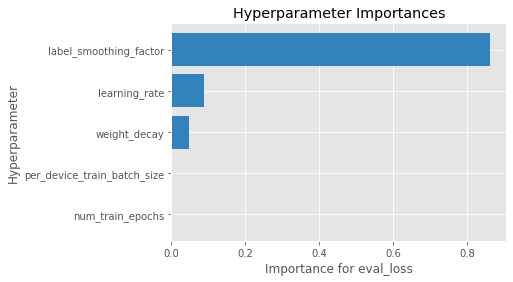

In [108]:
# from optuna.visualization import plot_param_importances
from optuna.visualization.matplotlib import plot_param_importances

fig = plot_param_importances(
    study, target=lambda t: t.values[0], target_name="eval_loss"
)
# fig.update_layout(autosize=False, width=800, height=350)
# fig.show()

In [109]:
fig = optuna.visualization.plot_slice(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
fig.update_layout(autosize=False, width=900, height=350)
fig.show()

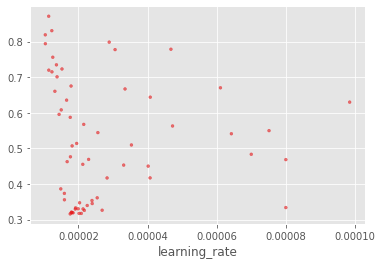

In [110]:
# plt.scatter(trial_df.eval_loss, trial_df.learning_rate, c=trial_df.best, cmap="Set1_r", alpha=0.6, s=8);
plt.scatter(trial_df.learning_rate, trial_df.eval_loss, c=trial_df.per_device_train_batch_size, cmap="Set1", alpha=0.6, s=8);
plt.xlabel("learning_rate");

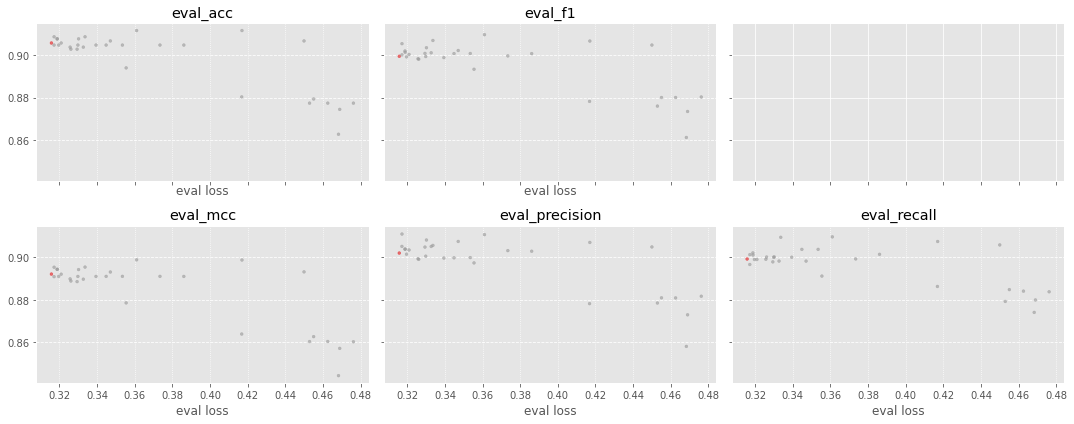

In [111]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
metrics = [m for m in trial_metrics_df.columns if m not in exclude]

# only focus on low loss trials
loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.median()]

for col, ax in zip(metrics, axs.flatten()):
    if col == "eval_loss":
        continue
    ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
    ax.set_title(col)
    ax.set_xlabel("eval loss")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

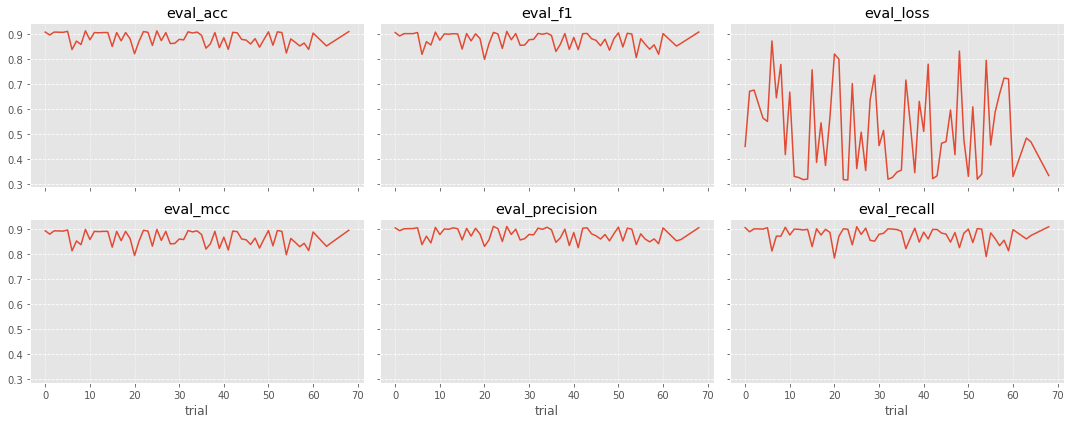

In [112]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True, sharey=True)

for col, ax in zip(metrics, axs.flatten()):
    trial_df[col].sort_index().plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel("trial")
    ax.grid(axis='y', linestyle='--', zorder=1)
    ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()